In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from gensim.models import Word2Vec
import xgboost as xgb
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss, mean_squared_log_error
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
import tqdm
import sys
import os
import gc
import argparse
import warnings
import lightgbm as lgb
from lightgbm import early_stopping
from lightgbm import log_evaluation
from sklearn.model_selection import StratifiedKFold, KFold
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import pickle
#计算shap值
import shap
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']=['SimHei']

In [79]:
pd.set_option('display.max_rows', None)  # 显示所有行
pd.set_option('display.max_columns', None)  # 显示所有列
pd.set_option('expand_frame_repr', False)  # 即“禁止换行”
# pd.set_option('display.precision', 2) #展示两位小数点
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
jy_df=pd.read_csv('data/账户交易信息.csv')
jy_df.columns = ['交易流水序号','账户代号','对方账号','借贷标志','交易金额','交易余额','对方行号','交易日期','交易时间','交易渠道','摘要代号','对方名称长度']
jt_df=pd.read_csv('data/账户静态信息.csv')
jt_df.columns = ['账户代号','开户日期','开户行代号','客户性别','年龄']
train_label=pd.read_csv('data/训练集标签.csv')
train_label.columns = ['账户代号','label']
test_df=pd.read_csv('data/test_dataset.csv')
test_df.columns = ['账户代号']## 读取数据

In [3]:
df_all=pd.concat([train_label,test_df])

In [4]:
df_all.head()

,账户代号,label
0,2029FF26D4E2CA79,0.0
1,09F5B90D46FB7CCE,1.0
2,E0C880EB18F4EFE8,1.0
3,ED8FFDCCF93C2F11,1.0
4,8D2F48B0BFC40AB2,1.0


# 特征处理

## 抹账处理

In [72]:
# 抹账交易序号
mz_index = [] ;

In [73]:
# 抹账数据处理
jy_mz_df=jy_df[jy_df['账户代号'].isin(jy_df[jy_df['交易金额']<0]['账户代号'].unique())].sort_values(by=['账户代号','交易日期','交易时间'],ascending=True)
jy_mz_df.index=range(len(jy_mz_df))
#待剔除数据
tc_idx=set()
for idx in jy_mz_df[jy_mz_df['交易金额']<0].index:
    for d in range(1,5):
        #print(idx)
        if -jy_mz_df.loc[idx,'交易金额']==jy_mz_df.loc[idx-d,'交易金额'] and jy_mz_df.loc[idx,'账户代号']==jy_mz_df.loc[idx-d,'账户代号']\
            and jy_mz_df.loc[idx,'对方账号']==jy_mz_df.loc[idx-d,'对方账号']:
                mz_time[jy_mz_df.loc[idx,'账户代号']] += 1 ;
                mz_sum[jy_mz_df.loc[idx,'账户代号']] += float(jy_mz_df.loc[idx-d,'交易金额'])
                mz_index.append(idx-d) ;
                tc_idx.add(idx)
                tc_idx.add(idx-d)
                break
tc_idx=list(tc_idx)
jy_clean_df=jy_mz_df[~jy_mz_df.index.isin(tc_idx)]
jy_clean_df=pd.concat([jy_clean_df,jy_df[jy_df['交易金额']>=0]])

In [74]:
# 取出抹账的数据
df_mz = jy_mz_df.loc[mz_index , ['账户代号' , '交易金额']] ;
df_mz_agg = df_mz.groupby('账户代号')['交易金额'].agg(['sum','count','mean','max','min','std',np.ptp]).reset_index() ;
df_mz_agg.columns = ['账户代号'] + ['抹账_'+ f for f in df_mz_agg.columns.values if f not in ['账户代号']]

In [115]:
jy_mz_df.loc[mz_index].sort_values(by='交易时间')['交易时间'] < "00:07:00"

18175      True
26139      True
140448     True
26141      True
91001      True
30349      True
150002     True
105095     True
103865     True
13265      True
103867     True
34868     False
3398      False
82229     False
166720    False
166721    False
116027    False
115493    False
41089     False
41091     False
115495    False
115497    False
78390     False
78389     False
57617     False
35439     False
83469     False
85369     False
32743     False
116019    False
172044    False
172046    False
52        False
81480     False
43221     False
76448     False
43224     False
43229     False
147140    False
39890     False
47162     False
24253     False
113147    False
19734     False
28476     False
113149    False
110570    False
66887     False
53805     False
110602    False
141775    False
58157     False
58159     False
28480     False
2821      False
19962     False
117135    False
139791    False
122728    False
147520    False
43754     False
177505    False
110471  

## 深夜交易

,交易流水序号,账户代号,对方账号,借贷标志,交易金额,交易余额,对方行号,交易日期,交易时间,交易渠道,摘要代号,对方名称长度
13265,FFEC635762DC55C39330142BA6638943,1883186CE085408F,36ECFE390598418C,0,500.00,78000.19,CAD56B44,2020-05-27,00:05:54,091D584F,A97DA629,6
18175,0DC3B48D518D86E5E3051BDBE9B73B53,1E65D58BC279D085,45307F42F82C2595,0,5000.00,5170.13,98CB458A,2020-05-15,00:00:56,091D584F,A97DA629,9
26139,A74B5A2CA9772CBFA32C437108DE301F,2DD9D8439D734C61,B29DB6EE968C19D8,0,3000.00,4779.61,98CB458A,2020-03-29,00:01:56,091D584F,A97DA629,6
26141,1C986B2129829A3F50682B02B87CD6CE,2DD9D8439D734C61,B29DB6EE968C19D8,0,3000.00,4779.61,98CB458A,2020-03-29,00:02:49,091D584F,A97DA629,6
30349,00F13D477F708DB3C01D96A7DE3B98BF,345EDA56977F5289,253E1DB017B26339,0,10000.00,24093.02,CAD56B44,2020-05-30,00:03:35,091D584F,A97DA629,6
91001,85A22049E865CE8C201A1F7253C88DE4,92D67A0F7FDB274C,57A88077F31BE159,0,5500.00,947.54,2BE0C959,2020-04-22,00:02:59,091D584F,A97DA629,9
103865,DAE6E128FD398B3F8C37957955C6CBB6,AB968F0C19B4E2D3,79B469C0C8163600,0,11993.00,0.50,8846C067,2020-05-03,00:04:51,091D584F,A97DA629,9
103867,3DFCDC658805C01AF30513DEC6302434,AB968F0C19B4E2D3,79B469C0C8163600,0,11993.00,0.50,8846C067,2020-05-03,00:06:14,091D584F,A97DA629,9
105095,8357B64F9106414723279B4174A12729,AC6BDC405AAB8E9D,15DB5BF8B707F66C,0,4000.00,125.26,583BDDDA,2020-03-19,00:04:21,091D584F,A97DA629,6
140448,A4E4F46005DDCE31D4F48156B05F1EF0,D982ECD4C4453EF2,E7E7AB540C5C28CF,0,3000.00,608.16,98CB458A,2020-04-20,00:02:18,091D584F,A97DA629,36


In [75]:
df_mz_agg.head()

,账户代号,抹账_sum,抹账_count,抹账_mean,抹账_max,抹账_min,抹账_std,抹账_ptp
0,00037295453A928A,4600.0,1,4600.0,4600.0,4600.0,NaN,0.0
1,000AA77144DC1BCC,3.0,2,1.5,2.0,1.0,0.707107,1.0
2,0046934E42BB38B7,99.0,1,99.0,99.0,99.0,NaN,0.0
3,005D7A6EF2DD90C9,11050.0,1,11050.0,11050.0,11050.0,NaN,0.0
4,0146ED21079D88CF,103648.0,2,51824.0,100000.0,3648.0,68131.152581,96352.0


## 夜间交易处理

In [77]:
df_all=df_all.merge(df_mz_agg,on='账户代号',how='left') ;

In [84]:
train_label = df_all[:len(train_label)] ;
test_label = df_all[len(train_label):] ;

In [85]:
def corr_filter(train_data,corr_threshold):
    corr_data=train_data.corr()
    corr_data=corr_data.where(np.triu(np.ones(corr_data.shape),k=1).astype(np.bool))
    high_corr=[column for column in corr_data.columns if any(corr_data[column].abs()>corr_threshold)]
    result=[c for c in train_data.columns if c not in high_corr]
    print("筛选后特征:",len(result))
    return result

In [91]:
cols = [f for f in train_label.columns if f not in ['账户代号','label']]

In [ ]:
cols =corr_filter(train_label[cols],0.95)

In [88]:
def 对抗验证获取数据(df_train,df_test,threshold):
    # 定义新的Y
    
    
    df_train['Is_Test'] = 0
    df_test['Is_Test'] = 1
    #print(df_train.columns)
    #print(df_test.columns)
    # 将 Train 和 Test 合成一个数据集。
    df_adv = pd.concat([df_train, df_test])
    #print(df_adv.columns)
    #catecol_list_index=[list(df_train.columns).index(c) for c in df_train.select_dtypes(include=['category']).columns]
    # 通过抗验证中的模型，得到各个样本属于测试集的概率


    
    model_adv =  lgb.LGBMClassifier()
    model_adv.fit(df_adv.drop(['label','Is_Test'], axis=1), df_adv.loc[:, 'Is_Test'])
    preds_adv = model_adv.predict_proba(df_adv.drop(['label','Is_Test'], axis=1))[:, 1]
    
    df_train_copy = df_train.copy()
    df_train_copy['is_test_prob'] = preds_adv[:len(df_train)]

    # 根据概率排序
    df_train_copy = df_train_copy.sort_values('is_test_prob').reset_index(drop=True)

    # 将概率最大的20%作为验证集
    df_validation_2 = df_train_copy.iloc[int(threshold * len(df_train)):, ]
    df_train_2 = df_train_copy.iloc[:int(threshold * len(df_train)), ]
    return df_validation_2.drop(['is_test_prob','Is_Test'], axis=1)#,df_train_copy.drop(['Is_Test'],axis=1)
def 对抗验证获得新的列(df_train,df_test,threshold):
    # 定义新的Y
    df_train['Is_Test'] = 0
    df_test['Is_Test'] = 1

    # 将 Train 和 Test 合成一个数据集。
    df_adv = pd.concat([df_train, df_test])

    # 通过抗验证中的模型，得到各个样本属于测试集的概率
    other_param={'boosting_type':'gbdt','num_leaves':32,'max_depth':10,'n_estimators':200,'objective':'binary','subsample':0.7,'colsample_bytree':0.8,'subsample_freq':1,
               'min_child_weight':0.9,'learning_rate':0.08}
    model_adv =  lgb.LGBMClassifier(**other_param)
    model_adv.fit(df_adv.drop('Is_Test', axis=1), df_adv.loc[:, 'Is_Test'])
    #preds_adv = model_adv.predict_proba(df_adv.drop('Is_Test', axis=1))[:, 1]
    
    im=pd.DataFrame({'colname':df_train.drop(['Is_Test'],axis=1).columns,'importance':model_adv.feature_importances_})

    im=im.sort_values(by='importance',ascending=False)
        
    new_cat=im.reset_index().loc[round(len(im)*threshold):,'colname']
    print('对抗验证后的特征数量为:',len(new_cat))
    return new_cat

In [94]:
new_cat=对抗验证获得新的列(train_label[cols].copy(),test_label[cols].copy(),0.6)
cols=list(new_cat)
col_valid=cols.copy()
col_valid.append('label')
valid=对抗验证获取数据(train_label[col_valid].copy(),test_label[cols].copy(),0.8)

对抗验证后的特征数量为: 3


In [97]:
new_cat.head()

4      抹账_std
5    抹账_count
6      抹账_ptp
Name: colname, dtype: object

In [98]:
def cv_model(clf, train_x, train_y, test_x, clf_name,valid_x):
    folds = 5
    seed = 2023
    kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    
    oof = np.zeros(train_x.shape[0])
    predict = np.zeros(test_x.shape[0])
    predict_valid = np.zeros(valid_x.shape[0])
    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.01,
                'seed': 2020,
                'n_jobs':8
            }

            model = clf.train(params, train_matrix, 10000, valid_sets=[train_matrix, valid_matrix], 
                              categorical_feature=[], verbose_eval=200, early_stopping_rounds=200)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
            print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            test_matrix = clf.DMatrix(test_x)
            
            params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.05,
                      'tree_method': 'exact',
                      'seed': 2020,
                      'nthread': 8
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=10000, evals=watchlist, verbose_eval=1000, early_stopping_rounds=500)
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred = model.predict(test_matrix , ntree_limit=model.best_ntree_limit)
            
            valid_dk_matrix = clf.DMatrix(valid_x)
            valid_pred= model.predict(valid_dk_matrix, ntree_limit=model.best_ntree_limit)
        if clf_name == "cat":
            model = clf(
                        n_estimators=10000,
                        random_seed=2023,
                        eval_metric='AUC',
                        learning_rate=0.05,
                        max_depth=7,
                        early_stopping_rounds=200,
                        metric_period=500,
                    )

            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      use_best_model=True,
                      verbose=1)
            
            val_pred  = model.predict_proba(val_x)[:,1]
            test_pred = model.predict_proba(test_x)[:,1]
            valid_pred= model.predict_proba(valid_x)[:,1]
            
        oof[valid_index] = val_pred
        predict += test_pred / kf.n_splits
        predict_valid +=valid_pred / kf.n_splits
        cv_scores.append(roc_auc_score(val_y, val_pred))
        print(cv_scores)
       
    return oof, predict,predict_valid,model

In [99]:
xgb_oof, xgb_pred,xgb_valid_pred,clf = cv_model(CatBoostClassifier, train_label[cols], train_label['label'], test_label[cols], 'cat',valid[cols])
#xgb_oof, xgb_pred,xgb_valid_pred,clf = cv_model(xgb, train_label[cols], train_label['label'], test_label[cols], 'xgb',valid[cols])


************************************ 1 ************************************
0:	test: 0.5552778	best: 0.5552778 (0)	total: 142ms	remaining: 23m 39s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.585787037
bestIteration = 10

Shrink model to first 11 iterations.
[0.585787037037037]
************************************ 2 ************************************
0:	test: 0.5581481	best: 0.5581481 (0)	total: 1.2ms	remaining: 12s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.5906018519
bestIteration = 11

Shrink model to first 12 iterations.
[0.585787037037037, 0.5906018518518519]
************************************ 3 ************************************
0:	test: 0.5527778	best: 0.5527778 (0)	total: 862us	remaining: 8.62s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.580787037
bestIteration = 2

Shrink model to first 3 iterations.
[0.585787037037037, 0.5906018518518519, 0.5807870370370372]
************************************ 4 ************************************
0:	test: 0.5506944	best: 0.5506944 (0)	total: 891us	remaining: 8.91s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.6206018519
bestIteration = 20

Shrink model to first 21 iterations.
[0.585787037037037, 0.5906018518518519, 0.5807870370370372, 0.6206018518518518]
************************************ 5 ************************************
0:	test: 0.5668519	best: 0.5668519 (0)	total: 1.03ms	remaining: 10.3s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.607037037
bestIteration = 2

Shrink model to first 3 iterations.
[0.585787037037037, 0.5906018518518519, 0.5807870370370372, 0.6206018518518518, 0.6070370370370369]


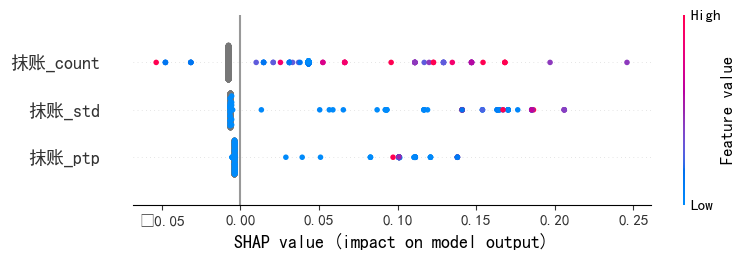

In [100]:

explainer = shap.TreeExplainer(clf)

shap_values = explainer.shap_values(train_label[cols])
#shap.summary_plot(shap_values[1], train_label[cols])
shap.summary_plot(shap_values, train_label[cols])

In [101]:
wrap_features=pd.DataFrame()
wrap_features['cols']=cols
wrap_features['shap']=abs(shap_values).sum(axis=0)
wrap_features.sort_values(by='shap',ascending=False,inplace=True)
wrap_features.index=range(len(wrap_features))
wrap_features=wrap_features[:100]['cols']

In [102]:
#xgb_oof, xgb_pred,xgb_valid_pred,clf = cv_model(CatBoostClassifier, train_label[cols], train_label['label'], test_label[cols], 'cat',valid.drop('label',axis=1))
xgb_oof, xgb_pred,xgb_valid_pred,clf = cv_model(xgb, train_label[wrap_features], train_label['label'], test_label[wrap_features], 'xgb',valid[wrap_features])

************************************ 1 ************************************
[0]	train-auc:0.55625	eval-auc:0.55556
[516]	train-auc:0.60063	eval-auc:0.58616
[0.5863888888888888]
************************************ 2 ************************************
[0]	train-auc:0.55694	eval-auc:0.55000
[751]	train-auc:0.59927	eval-auc:0.59042
[0.5863888888888888, 0.5905092592592592]
************************************ 3 ************************************
[0]	train-auc:0.56319	eval-auc:0.55000
[503]	train-auc:0.60109	eval-auc:0.57981
[0.5863888888888888, 0.5905092592592592, 0.5800925925925927]
************************************ 4 ************************************
[0]	train-auc:0.55486	eval-auc:0.53611
[522]	train-auc:0.59198	eval-auc:0.62051
[0.5863888888888888, 0.5905092592592592, 0.5800925925925927, 0.6206018518518518]
************************************ 5 ************************************
[0]	train-auc:0.55347	eval-auc:0.56667
[510]	train-auc:0.59487	eval-auc:0.60718
[0.5863888888888

In [103]:
oof = xgb_oof
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.6,0.01):
    preds = (oof.reshape((-1))>threshold).astype('int')
    m = f1_score(train_label['label'].values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold
    print(f'{threshold:.02f}, {m}')
print(f'最高分:{best_threshold:.2f}, {best_score}')

m_valid = f1_score(valid['label'].values, (xgb_valid_pred>best_threshold).astype('int'), average='macro')   

print(f'对抗验证分:{m_valid}')
# 0.47, 0.9150898680694286 # 0.86579572447
# 0.43, 0.9217716422203048 # 0.86697783
# 0.41, 0.9198568108353592 # 0.87674418605
# 0.40, 0.9231997065541027 # 0.87819025522
# 0.42, 0.913822737200522  # 0.87639132982 
# 0.40, 0.9148403872302214 # 0.88313184

0.40, 0.571247267306912
0.41, 0.5704535112998634
0.42, 0.5613569882651599
0.43, 0.5613569882651599
0.44, 0.5598826353694318
0.45, 0.5676743656105072
0.46, 0.5578036520964561
0.47, 0.5558514179203834
0.48, 0.5558514179203834
0.49, 0.545751633986928
0.50, 0.5415466479034281
0.51, 0.5423296204660806
0.52, 0.5197395313330077
0.53, 0.5168475157053112
0.54, 0.5168475157053112
0.55, 0.5120431893687708
0.56, 0.4914775402580281
0.57, 0.4861913937058445
0.58, 0.4743805847062874
0.59, 0.45844385499557916
最高分:0.40, 0.571247267306912
对抗验证分:0.4508906684098709


In [104]:
pred = xgb_pred
test_label['label'] = (pred.reshape((-1))>0.42).astype('int')
result=test_label[['账户代号','label']]
result.columns=['zhdh','black_flag']
result.to_csv('submission20230305.csv', index=False)
result['black_flag'].value_counts()

0    4214
1     586
Name: black_flag, dtype: int64